In [2]:
import Pkg; Pkg.instantiate()
Pkg.activate(".")
using DrugResponseModel
using Plots, LinearAlgebra
concs, populations1, g1s1, g2s1 = load(189, 1);
concs, populations2, g1s2, g2s2 = load(189, 2);
concs, populations3, g1s3, g2s3 = load(189, 3);
g0 = g1s1[1,1,1]+g2s1[1,1,1];

g1avg = (g1s1 .+ g1s2 .+ g1s3) ./ 3; # pure data
g2avg = (g2s1 .+ g2s2 .+ g2s3) ./ 3; # pure data

#---- traditional approach
#BlissOnData = blissCellNum(g1avg, g2avg; T=96, n=8)
#----

#---- our approach
paramAvg = [49.2322, 1.13253, 0.0557782, 3.43847, 0.0183834, 0.0530674, 0.538046, 
               58.3661, 1.7259, 2.69584, 0.0578749, 0.475825, 0.537772, 0.544677, 
               20.8855, 2.05741, 2.05982, 4.99875, 0.0697081, 0.359285, 0.496691, 
               3.9771, 4.8181, 0.0587329, 1.82322, 0.633786, 0.445822, 0.498424, 
               40.3828, 1.08046, 0.653381, 3.35693, 0.0426125, 0.0648354, 0.535886, 
               1.92651, 1.77876, 42.2714, 56.3408, 37.3421, 17.6778];

#efcs = getODEparamsAll(paramAvg, concs);

 Activating environment at `~/ODE/DrugResponseModel.jl/Project.toml`


In [3]:
p_optim, best = DrugResponseModel.optimize_hillAll(concs, g1avg, g2avg)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
100.05 secs, 532 evals, 417 steps, improv/step: 0.384 (last = 0.3837), fitness=5581.579952898
DE modify state:
200.30 secs, 958 evals, 840 steps, improv/step: 0.329 (last = 0.2742), fitness=4967.107396505
DE modify state:
300.45 secs, 1337 evals, 1219 steps, improv/step: 0.295 (last = 0.2216), fitness=4166.223184401
DE modify state:
400.59 secs, 1906 evals, 1788 steps, improv/step: 0.263 (last = 0.1951), fitness=4042.616102835
DE modify state:
500.69 secs, 2444 evals, 2326 steps, improv/step: 0.244 (last = 0.1784), fitness=3964.245276525
DE modify state:
600.81 secs, 3021 evals, 2903 steps, improv/step: 0.232 (last = 0.1837), fitness=3713.597138897
DE modify state:
700.98 secs, 3586 evals, 3468 steps, i

(1887.1383886112544, [50.99188110295996, 1.1781751582377844, 0.0561334653681162, 0.7596564768296694, 0.02354108093080326, 0.06026632534096947, 0.548224923858207, 98.03794040071648, 1.3303043028340569, 0.9947768593219818  …  0.7549816581022946, 0.049980432129324515, 0.07285043441179083, 0.542676079821521, 2.0371126163381295, 0.37657073274522285, 44.17832690960963, 12.802946717222627, 25.96813570717159, 13.957374959003392])

In [12]:
round(12.44678, digits=2)

12.45

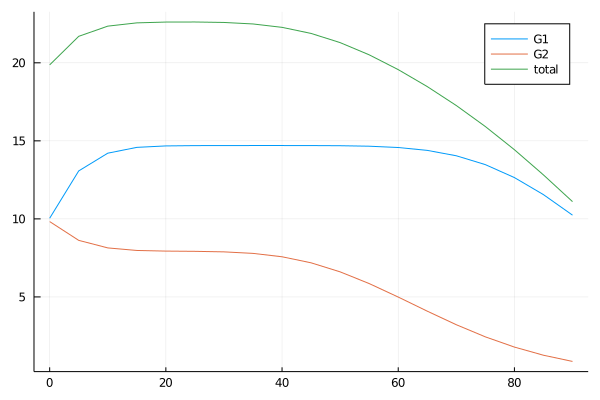

In [10]:
paramAvg = [50.9919, 1.17818, 0.0561335, 0.759656, 0.0235411, 0.0602663, 0.548225, 
            98.0379, 1.3303, 0.994777, 0.0500693, 0.462114, 0.582957, 0.553253, 
            16.6879, 2.27928, 0.99894, 0.782578, 0.0205941, 0.27198, 0.503975, 
            3.98399, 4.36471, 0.0801577, 0.304947, 0.472025, 0.336453, 0.505411, 
            50.6239, 1.03073, 0.565949, 0.754982, 0.0499804, 0.0728504, 0.542676, 
            2.03711, 0.376571, 44.1783, 12.8029, 25.9681, 13.9574];

EC50s = [paramAvg[1], paramAvg[8], paramAvg[15], paramAvg[22], paramAvg[29]]

function paramsAtEC50(p)
    ps = zeros(9, 5) # num_parameters x number of drugs.
    k = 1
    for i =1:5
        ps[:, i] = [0.5*(p[36] + p[k + 2]), 0.5*(p[37] + p[k + 3]), 0.5*p[k + 4], 0.5*p[k + 5], p[k + 6], floor(p[38]), floor(p[39]), floor(p[40]), floor(p[41])]
        k += 7
    end
    return ps
end

params = paramsAtEC50(paramAvg)

function BlissUnit(p1, p2)
    # p1 and p2 are Arrays 9x1 and are assumed to be from the EC50 concentration.
    combin = similar(p1)
    combin[1:2] .= p1[1:2] .+ p2[1:2] .- p1[1:2] .* p2[1:2]
    combin[3:4] .= p1[3:4] .+ p2[3:4]
    combin[5:end] .= p1[5:end]
    return combin
end

combin = BlissUnit(params[:, 4], params[:, 5]) # lpt and dox

tim = 0.0:5:90.0
G1, G2 = predict(combin, g1avg[1] + g2avg[1], tim)

plot(tim, G1, label="G1")
plot!(tim, G2, label="G2")
plot!(tim, G1 .+ G2, label="total")


In [7]:
function BlissUnit(p1, p2)
    # p1 and p2 are Arrays 9x1 and are assumed to be from the EC50 concentration.
    combin = similar(p1)
    combin[1:2] .= p1[1:2] .+ p2[1:2] .- p1[1:2] .* p2[1:2]
    combin[3:4] .= p1[3:4] .+ p2[3:4]
    combin[5:end] .= p1[5:end]
    return combin
end
p1 = efcs[:, 1, 1]
p2 = efcs[:, 1, 2]

9-element Array{Float64,1}:
  1.9265139124255026
  1.7787512484437724
  2.419806669230713e-6
  2.7348379595976235e-6
  0.544677
 42.2714
 56.3408
 37.3421
 17.6778

In [8]:
BlissUnit(p1, p2)

9-element Array{Float64,1}:
  0.14228143788423564
  0.3930133266623894
  9.90616145525982e-6
  2.43457142921651e-5
  0.538046
 42.2714
 56.3408
 37.3421
 17.6778